Churn prediction
-------------------
Company churn occurs when companies cancel subscriptions or subscriptions expires without renewals.  
This notebook uses XGBoost to predict Churn, and GridSearchCV to perform hyperparameter tuning.   

**Note:**
- both setup completed and not completed accounts are included.

In [0]:
import mlflow
import mlflow.sklearn
from datetime import datetime

mlflow.set_experiment("/Users/bxing@actsoft.com/Churn/XGBoost/Churn_XGBoost_All_SHAP")

# date that license deactivation will check against in determinding churn or no-churn,
# usually the date that data storage was created.
pred_datetime = datetime(2020, 7, 21)
mlflow.log_param("End date", pred_datetime)

# start datetime for license activation.
start_dateime = datetime(2000, 1, 1)
mlflow.log_param("Start date", start_dateime)

# include both registered and non registered users
registered_only = False
mlflow.log_param("Setup complete", registered_only)

2021/01/14 22:52:49 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
 - be included in your $PATH
 - be set via $GIT_PYTHON_GIT_EXECUTABLE
 - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
 - quiet|q|silence|s|none|n|0: for no warning or exception
 - warn|w|warning|1: for a printed warning
 - error|e|raise|r|2: for a raised exception

Example:
 export GIT_PYTHON_REFRESH=quiet

In [0]:
%run /Users/bxing@actsoft.com/Churn/Churn_Dataframe

all companies with licenses: 14736

**Impose further limit on licenses**

In [0]:
# df = df[df.Licenses >= license_limit]
# df.shape

Out[18]: (10295, 24)

Out[19]:

,CompanyId,InstanceId,CompanyName,Tier,IsSetupComplete,UserIntegrationType,AccountId,AccountName,City,RegionName,PostalCode,CountryCode,Culture,Activation,Expiration,Deactivation,Duration,Churn,Licenses,Incidents,Trips,Forms,Timekeeping,Orders
0,822,50,None,10,True,0,694,Ward Alternative Energy,Fort Collins,Colorado,80521,US,en-US,2016-01-21,None,2020-09-19 00:00:44.750,1643,0,9,0,2819,0,66,0
1,872,50,None,30,True,0,744,TECS ELECTRIC LTD,Weatherford,TX,76087,US,en-US,2016-01-27,None,NaT,1637,0,43,0,0,5,4,624
2,965,53,None,10,True,0,21488,Southwest Center,Louisville,KY,40258,US,en-US,2018-02-26,None,NaT,876,0,17,9,18790,1,0,0
3,1027,50,None,10,True,0,899,Hood River Taxi,Hood River,Oregon,97031,US,en-US,2016-02-12,None,2016-09-10 13:06:52.400,211,1,8,0,922,0,0,0
4,1107,50,None,10,True,0,979,AAA Signs Inc,Sacramento,California,95815,US,en-US,2016-03-04,None,2017-12-21 00:13:54.140,657,1,34,0,16683,2,0,6


In [0]:
df.describe(include='all')

Out[22]:

,CompanyId,InstanceId,CompanyName,Tier,IsSetupComplete,UserIntegrationType,AccountId,AccountName,City,RegionName,PostalCode,CountryCode,Culture,Activation,Expiration,Deactivation,Duration,Churn,Licenses,Incidents,Trips,Forms,Timekeeping,Orders
count,10295.000000,10295.000000,23,10295.000000,10295,10295.000000,10295.000000,10295,9535,2765,9422,10295,10295,10295,5661,6802,10295.000000,10295.000000,10295.000000,10295.000000,1.029500e+04,1.029500e+04,10295.000000,10295.000000
unique,NaN,NaN,23,NaN,2,NaN,NaN,10167,4217,110,5491,8,1,1625,1165,6783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,ALLSTAR SYSTEMS,NaN,False,NaN,NaN,TRACFONE,LAS VEGAS,CA,80112,US,en-US,2017-08-31 00:00:00,2018-03-02,2019-07-04 00:14:04.060000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,1,NaN,6008,NaN,NaN,12,165,293,23,10224,10295,45,111,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-08-06 00:00:00,NaN,2016-09-10 13:04:33.370000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-20 00:00:00,NaN,2021-01-14 00:00:57.360000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,11203.335697,50.354347,NaN,15.641574,NaN,0.001748,11227.448276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,471.716270,0.599029,31.565712,0.643031,1.798728e+04,2.574596e+03,199.520350,136.717436
std,9613.063397,0.968282,NaN,7.834202,NaN,0.083614,6523.515600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,409.336589,0.490119,604.214272,7.945799,1.345513e+06,2.129678e+05,2214.794756,2007.368284
min,109.000000,50.000000,NaN,2.000000,NaN,0.000000,195.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,3743.000000,50.000000,NaN,10.000000,NaN,0.000000,5695.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130.000000,0.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000


Categorical feature distributions

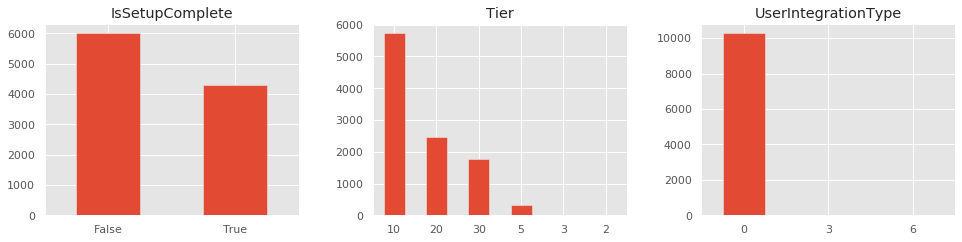

In [0]:
# categorical_features = ["IsSetupComplete", Tier", "UserIntegrationType"]

plt.style.use('ggplot')

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
for i, categorical_feature in enumerate(categorical_features):
  df[categorical_feature].value_counts().plot(kind='bar', ax=ax[i], rot=0).set_title(categorical_feature)

fig.tight_layout(pad=3.0)

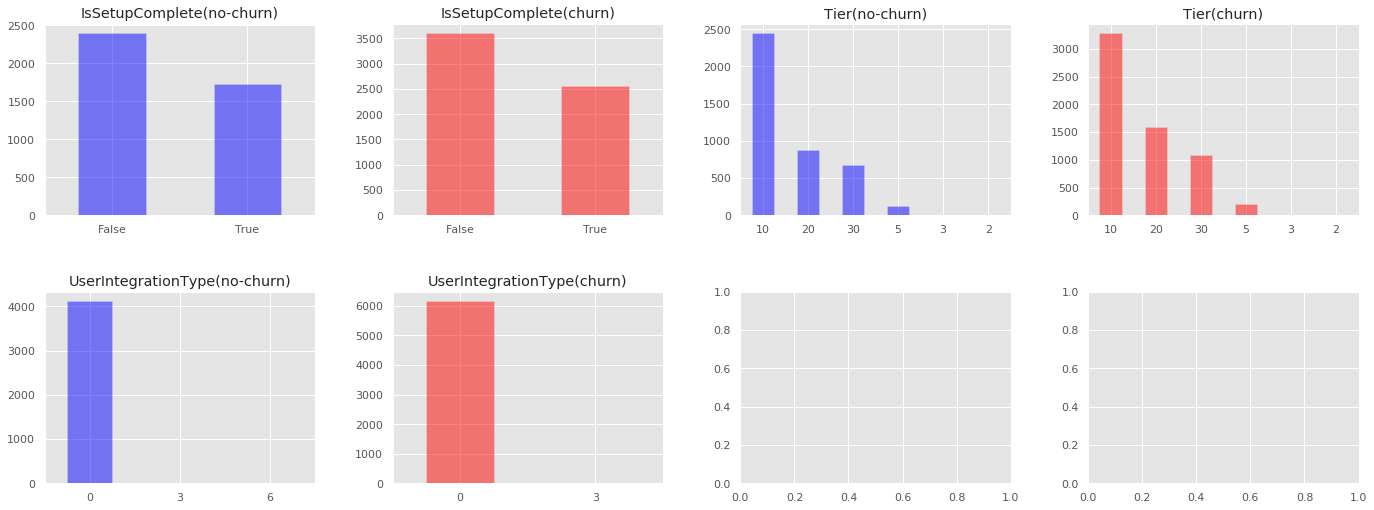

In [0]:
plt.style.use('ggplot')

# 2 row 4 col
fig, ax = plt.subplots(2, 4, figsize=(20, 8))

df[df.Churn == False]['IsSetupComplete'].value_counts().plot(kind='bar', color="blue", alpha=0.5, ax=ax[0, 0], rot=0).set_title('IsSetupComplete(no-churn)')
df[df.Churn == True]['IsSetupComplete'].value_counts().plot(kind='bar', color="red", alpha=0.5, ax=ax[0, 1], rot=0).set_title('IsSetupComplete(churn)')

df[df.Churn == False]['Tier'].value_counts().plot(kind='bar', color="blue", alpha=0.5, ax=ax[0, 2], rot=0).set_title('Tier(no-churn)')
df[df.Churn == True]['Tier'].value_counts().plot(kind='bar', color="red", alpha=0.5, ax=ax[0, 3], rot=0).set_title('Tier(churn)')

df[df.Churn == False]['UserIntegrationType'].value_counts().plot(kind='bar', color="blue", alpha=0.5, ax=ax[1, 0], rot=0).set_title('UserIntegrationType(no-churn)')
df[df.Churn == True]['UserIntegrationType'].value_counts().plot(kind='bar', color="red", alpha=0.5, ax=ax[1, 1], rot=0).set_title('UserIntegrationType(churn)')

fig.tight_layout(pad=4.0)

Numerical feature distributions

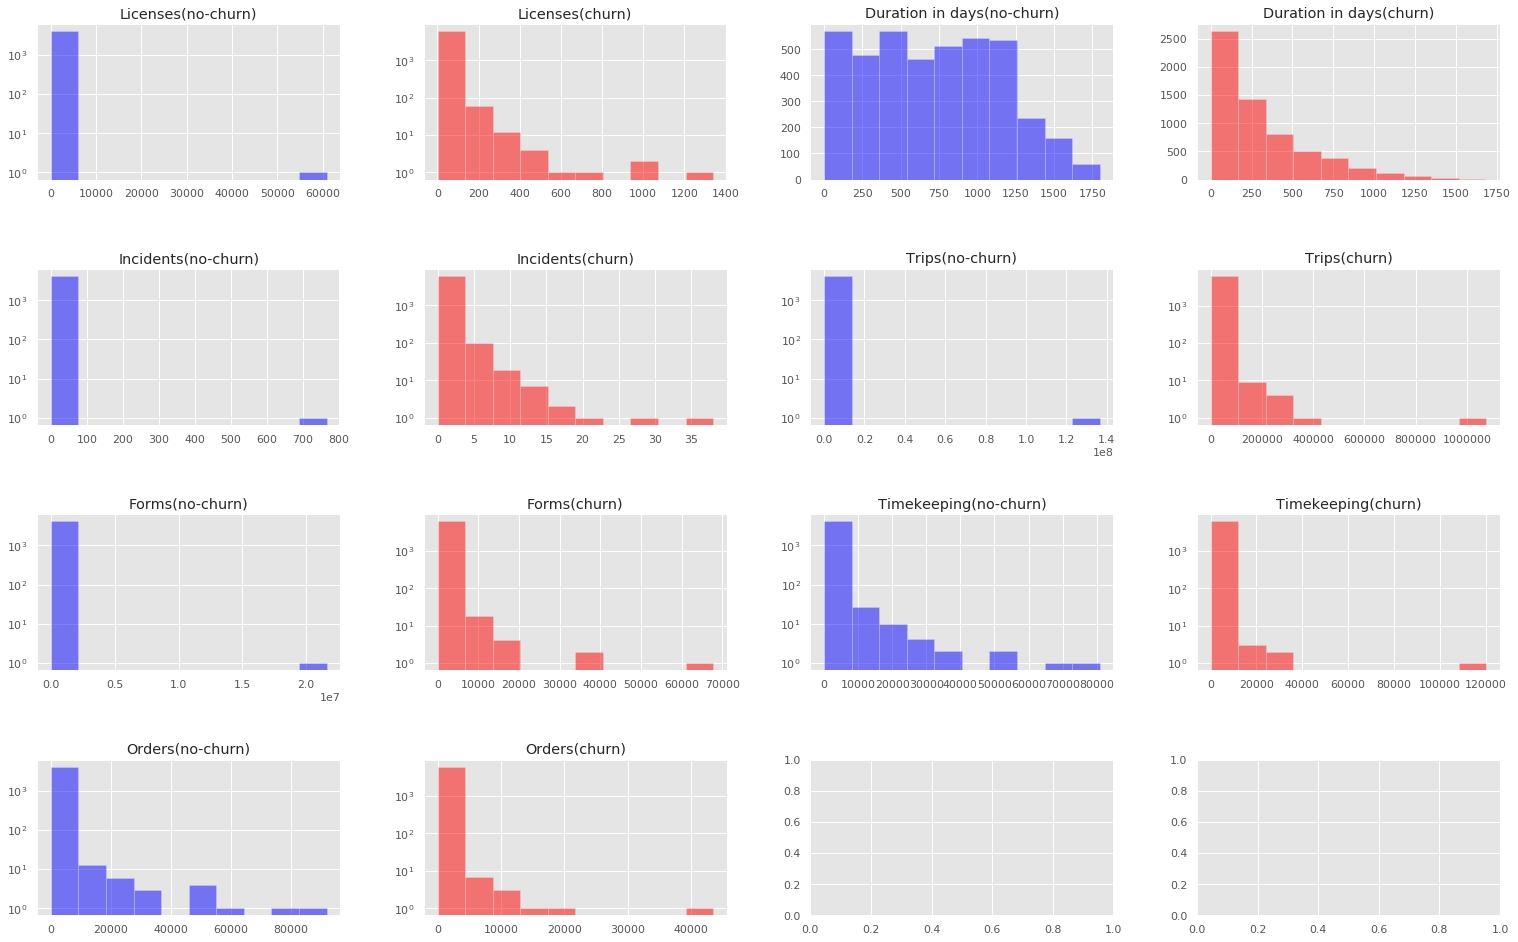

In [0]:
# numerical_features = ["Licenses", "Duration", "Incidents", "Trips", "Forms", "Timekeeping", "Orders"]

plt.style.use('ggplot')

rows, columns = 4, 4
fig, ax = plt.subplots(rows, columns, figsize=(22, 14))

df[df.Churn == False]["Licenses"].hist(bins=10, color="blue", alpha=0.5, ax=ax[0, 0]).set_title("Licenses(no-churn)")
df[df.Churn == True]["Licenses"].hist(bins=10, color="red", alpha=0.5, ax=ax[0, 1]).set_title("Licenses(churn)")
ax[0, 0].set_yscale('log')
ax[0, 1].set_yscale('log')

df[df.Churn == False]["Duration"].hist(bins=10, color="blue", alpha=0.5, ax=ax[0, 2]).set_title("Duration in days(no-churn)")
df[df.Churn == True]["Duration"].hist(bins=10, color="red", alpha=0.5, ax=ax[0, 3]).set_title("Duration in days(churn)")

df[df.Churn == False]["Incidents"].hist(bins=10, color="blue", alpha=0.5, ax=ax[1, 0]).set_title("Incidents(no-churn)")
df[df.Churn == True]["Incidents"].hist(bins=10, color="red", alpha=0.5, ax=ax[1, 1]).set_title("Incidents(churn)")
ax[1, 0].set_yscale('log')
ax[1, 1].set_yscale('log')

df[df.Churn == False]["Trips"].hist(bins=10, color="blue", alpha=0.5, ax=ax[1, 2]).set_title("Trips(no-churn)")
df[df.Churn == True]["Trips"].hist(bins=10, color="red", alpha=0.5, ax=ax[1, 3]).set_title("Trips(churn)")
ax[1, 2].set_yscale('log')
ax[1, 3].set_yscale('log')

df[df.Churn == False]["Forms"].hist(bins=10, color="blue", alpha=0.5, ax=ax[2, 0]).set_title("Forms(no-churn)")
df[df.Churn == True]["Forms"].hist(bins=10, color="red", alpha=0.5, ax=ax[2, 1]).set_title("Forms(churn)")
ax[2, 0].set_yscale('log')
ax[2, 1].set_yscale('log')

df[df.Churn == False]["Timekeeping"].hist(bins=10, color="blue", alpha=0.5, ax=ax[2, 2]).set_title("Timekeeping(no-churn)")
df[df.Churn == True]["Timekeeping"].hist(bins=10, color="red", alpha=0.5, ax=ax[2, 3]).set_title("Timekeeping(churn)")
ax[2, 2].set_yscale('log')
ax[2, 3].set_yscale('log')

df[df.Churn == False]["Orders"].hist(bins=10, color="blue", alpha=0.5, ax=ax[3, 0]).set_title("Orders(no-churn)")
df[df.Churn == True]["Orders"].hist(bins=10, color="red", alpha=0.5, ax=ax[3, 1]).set_title("Orders(churn)")
ax[3, 0].set_yscale('log')
ax[3, 1].set_yscale('log')

fig.tight_layout(pad=4.0)

Correlation Matrix and Heatmap

In [0]:
df_corr = df[categorical_features + [target] + numerical_features]

df_corr.corr()

Out[26]:

,IsSetupComplete,Tier,UserIntegrationType,Churn,Licenses,Duration,Incidents,Trips,Forms,Timekeeping,Orders
IsSetupComplete,1.000000,0.176612,-0.003524,-0.004035,0.022983,0.155917,0.089237,0.015826,0.014312,0.106651,0.080632
Tier,0.176612,1.000000,-0.006162,0.046006,-0.003954,0.025365,0.017241,-0.006700,-0.004838,0.076578,0.087475
UserIntegrationType,-0.003524,-0.006162,1.000000,-0.004225,0.002501,0.012582,0.007958,-0.000280,-0.000253,-0.001884,-0.001424
Churn,-0.004035,0.046006,-0.004225,1.000000,-0.026397,-0.500245,-0.055042,-0.014667,-0.014225,-0.056722,-0.061239
Licenses,0.022983,-0.003954,0.002501,-0.026397,1.000000,0.038044,0.950458,0.993913,0.993027,0.022133,0.008014
Duration,0.155917,0.025365,0.012582,-0.500245,0.038044,1.000000,0.068591,0.022817,0.021986,0.088627,0.088042
Incidents,0.089237,0.017241,0.007958,-0.055042,0.950458,0.068591,1.000000,0.949878,0.949142,0.063713,0.047204
Trips,0.015826,-0.006700,-0.000280,-0.014667,0.993913,0.022817,0.949878,1.000000,0.999357,0.008362,0.002518
Forms,0.014312,-0.004838,-0.000253,-0.014225,0.993027,0.021986,0.949142,0.999357,1.000000,0.006493,0.002205
Timekeeping,0.106651,0.076578,-0.001884,-0.056722,0.022133,0.088627,0.063713,0.008362,0.006493,1.000000,0.126040


Out[27]:

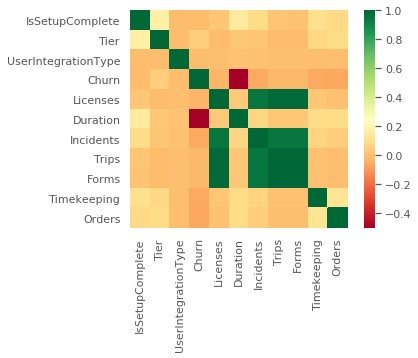

<matplotlib.axes._subplots.AxesSubplot at 0x7f523986ae50>

In [0]:
plt.style.use('ggplot')

sns.heatmap(df_corr.corr(), square=True, cmap='RdYlGn')

Sampled dataframe

In [0]:
df_sampled = df.sample(replace=False, frac=1, random_state=42)

df_sampled.shape
mlflow.log_param("dataset shape", df_sampled.shape)

**Training**

In [0]:
df_final = df_sampled[categorical_features + [target] + numerical_features]

X = df_final.loc[:, df_final.columns != 'Churn']
y = df_final.loc[:, df_final.columns == 'Churn']

In [0]:
# training the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from scipy.stats import uniform, randint

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

clf = XGBClassifier(random_state=42)

# **** RandomizedSearchCV *****
param_grid = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 1),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(3, 10), # default 6
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

tree_cv = RandomizedSearchCV(clf, param_distributions=param_grid, random_state=42, n_iter=200, cv=5, return_train_score=True)
mlflow.log_param("RandomizedSearchCV", 'scoring=default, n_iter=200, cv=5')

# **** GridSearchCV *****
# param_grid = {'max_depth': [6,7,8,9,10], #[7]
#               'learning_rate': np.linspace(0.05, 0.12, 5), #[0.052603876801838464],
#               'subsample': np.linspace(0.6, 1, 5), #[0.6763644124601385],
#               'colsample_bytree': np.linspace(0.8, 1, 5), #[0.8716877407512514],
#               'gamma': [0.9803315837160457],                    #np.linspace(0.8, 5, 5),
#               'n_estimators': [100, 120, 200] #[120]
#              }

# param_grid = {'max_depth': [7],
#               'learning_rate': np.linspace(0.05, 0.11, 10),
#               'subsample': [0.6763644124601385],
#               'colsample_bytree': [0.8716877407512514],
#               'gamma': [0.9803315837160457]
#              }

# tree_cv = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
# mlflow.log_param("GridSearchCV", 'cv=5')

tree_cv.fit(X_train, np.ravel(y_train))

pred = tree_cv.predict(X_test)

print("Tuned XGBoost: {}".format(tree_cv.best_params_))
print('Accuracy of XGBoost classifier on test set: {:.2f}'.format(tree_cv.score(X_test, y_test)))

# Log mlflow attributes for mlflow UI
mlflow.log_param("hyperparameters", tree_cv.best_params_)
mlflow.sklearn.log_model(tree_cv, "model")
mlflow.log_metric("accuracy", tree_cv.score(X_test, y_test))


Tuned XGBoost: {'colsample_bytree': 0.944979831841473, 'gamma': 0.4391349085702184, 'learning_rate': 0.14308332882747227, 'max_depth': 5, 'n_estimators': 137, 'subsample': 0.8159124247658532}
Accuracy of XGBoost classifier on test set: 0.77

**Testing **

In [0]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))

precision recall f1-score support

 0 0.78 0.64 0.70 1076
 1 0.77 0.87 0.82 1498

 accuracy 0.77 2574
 macro avg 0.77 0.75 0.76 2574
weighted avg 0.77 0.77 0.77 2574

In [0]:
report = classification_report(y_test, pred, output_dict=True)
# an easy workaround to log dictionary (nested) since log_metric doesn't support it.
mlflow.log_params(report)

Get model, class names & feature names

In [0]:
model = tree_cv.best_estimator_
class_names = [str(el) for el in model.classes_]
feature_names = categorical_features + numerical_features

print(model)
print("Feature names: {}".format(feature_names))
print("Class names: {}".format(class_names))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
 colsample_bynode=1, colsample_bytree=0.944979831841473,
 gamma=0.4391349085702184, gpu_id=-1, importance_type='gain',
 interaction_constraints='', learning_rate=0.14308332882747227,
 max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
 monotone_constraints='()', n_estimators=137, n_jobs=0,
 num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
 scale_pos_weight=1, subsample=0.8159124247658532,
 tree_method='exact', validate_parameters=1, verbosity=None)
Feature names: ['IsSetupComplete', 'Tier', 'UserIntegrationType', 'Licenses', 'Duration', 'Incidents', 'Trips', 'Forms', 'Timekeeping', 'Orders']
Class names: ['0', '1']

The following feature importances are not exactly same as SHAP. Be careful in their interpretation.    
The detailed reference can be found [here](https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=importance_type). A good review can be found [here](https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7).  

**"gain" types are most important: total gain & average gain across all trees.**

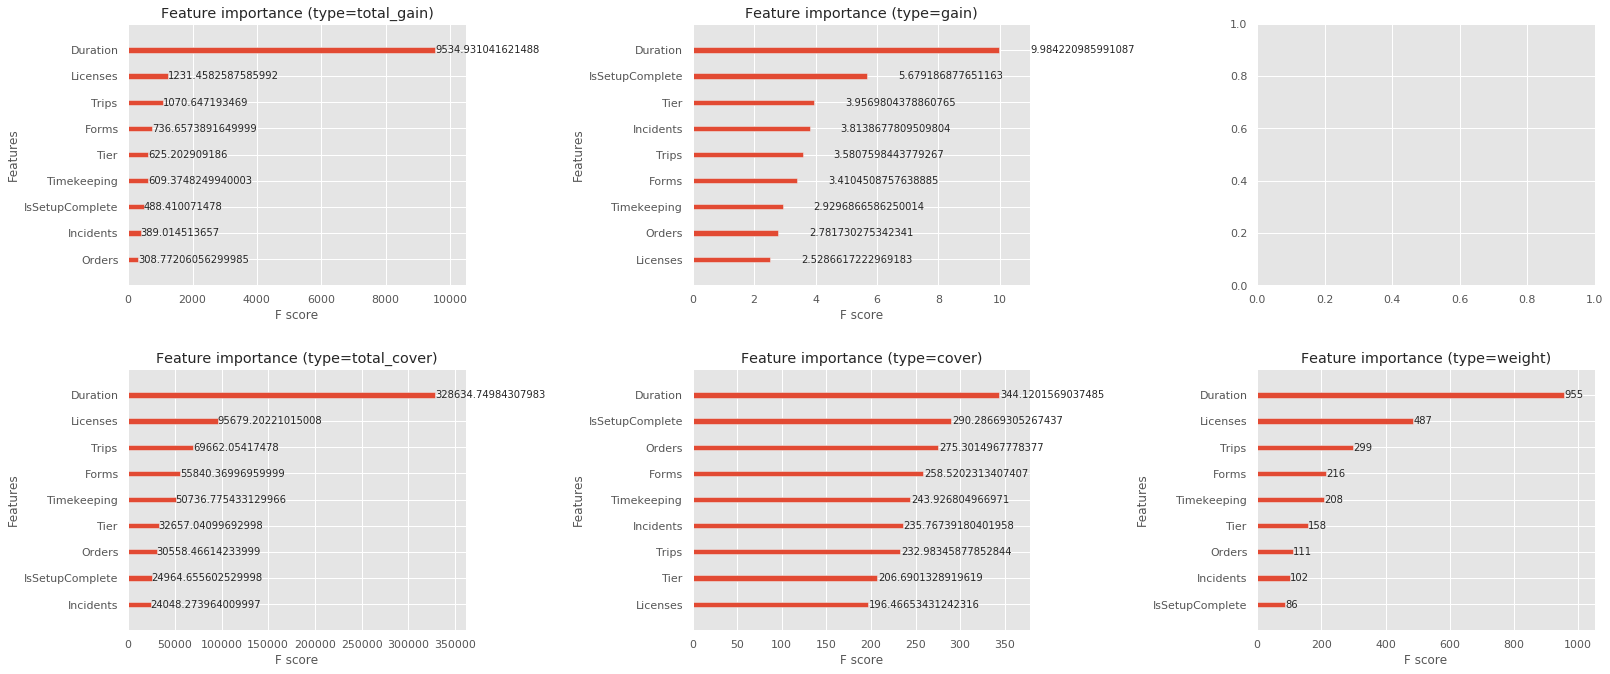

In [0]:
from xgboost import plot_importance

plt.style.use('ggplot')

fig, ax = plt.subplots(2, 3, figsize=(23, 10))

plot_importance(model, importance_type="total_gain", ax=ax[0,0])
ax[0,0].set_title('Feature importance (type=total_gain)')

plot_importance(model, importance_type="gain", ax=ax[0,1])
ax[0,1].set_title('Feature importance (type=gain)')

plot_importance(model, importance_type="total_cover", ax=ax[1,0])
ax[1,0].set_title('Feature importance (type=total_cover)')

plot_importance(model, importance_type="cover", ax=ax[1,1])
ax[1,1].set_title('Feature importance (type=cover)')

plot_importance(model, importance_type="weight", ax=ax[1,2])
ax[1,2].set_title('Feature importance (type=weight)')

fig.tight_layout(pad=3.0)

In [0]:
# from xgboost import plot_tree

# plt.style.use('dark_background')
# mpl.rcParams['text.color'] = 'black'

# fig, ax = plt.subplots(figsize=(40, 25))

# plot_tree(model, num_trees=4, ax = ax)

# plt.show()

ROC Curve for test data

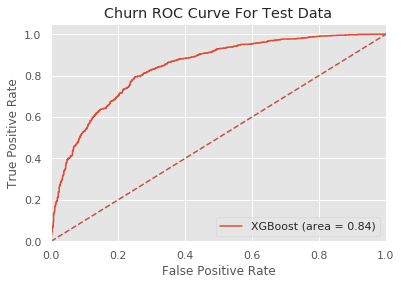

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

tree_roc_auc = roc_auc_score(y_test, tree_cv.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, tree_cv.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Churn ROC Curve For Test Data')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

ROC Curve for train data

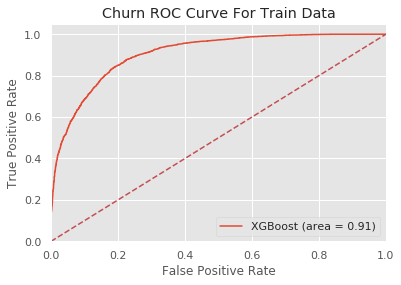

In [0]:
tree_roc_auc = roc_auc_score(y_train, tree_cv.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, tree_cv.predict_proba(X_train)[:,1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Churn ROC Curve For Train Data')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

In [0]:
mlflow.end_run()